In [2]:
!pip install sentencepiece
!pip install "accelerate>=0.26.0"
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset as TorchDataset, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import T5Tokenizer, T5ForConditionalGeneration
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print(torch.cuda.is_available())

Using device: cuda
True


In [4]:
user_sequences = {}
with open(r"D:\1513Project\ece1513project\ml-1m\user_sequences.txt", 'r') as f:
    for line in f:
        parts = line.strip().split('\t')
        user_id = parts[0]
        item_ids = parts[1].split() if len(parts) > 1 else []
        user_sequences[user_id] = item_ids

print(list(user_sequences.keys()))

moive_mapping = {}
with open(r"D:\1513Project\ece1513project\ml-1m\movies.dat", 'r', encoding = 'latin-1') as f:
    for line in f:
        parts = line.strip().split('::')
        if len(parts) >= 3:
            movie_id = int(parts[0])
            movie_text = parts[1] + ' ' + parts[2]
            moive_mapping[movie_id] = movie_text 

print(list(moive_mapping.values())[5])

user_ratings = {}
with open(r"D:\1513Project\ece1513project\ml-1m\ratings.dat", 'r') as f:
    for line in f:
        user_id, movie_id, rating, _ = line.strip().split("::")
        if user_id not in user_ratings:
            user_ratings[user_id] = {}
        user_ratings[user_id][movie_id] = rating 

print(user_ratings['1']['661'])

['6040', '6039', '6038', '6037', '6036', '6035', '6034', '6033', '6032', '6031', '6030', '6029', '6028', '6027', '6026', '6025', '6024', '6023', '6022', '6021', '6020', '6019', '6018', '6017', '6016', '6015', '6014', '6013', '6012', '6011', '6010', '6009', '6007', '6008', '6006', '6005', '6004', '6003', '6002', '6001', '6000', '5999', '5998', '5997', '5996', '5995', '5994', '5993', '5992', '5991', '5990', '5989', '5988', '5987', '5986', '5984', '5983', '5982', '5981', '5979', '5980', '5978', '5977', '5976', '5975', '5974', '5973', '5972', '5971', '5970', '5969', '5968', '5967', '5966', '5965', '5964', '5963', '5962', '5961', '5960', '5959', '5958', '5957', '5956', '5955', '5954', '5953', '5952', '5951', '5950', '5948', '5947', '5946', '5945', '5944', '5943', '5942', '5941', '5940', '5939', '5938', '5937', '5949', '5936', '5935', '5934', '5933', '5932', '5931', '5930', '5929', '5928', '5927', '5926', '5925', '5924', '5923', '5922', '5921', '5920', '5919', '5918', '5917', '5916', '5915',

In [5]:
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
t5_model  = T5ForConditionalGeneration.from_pretrained(
    "google/flan-t5-large",
    device_map="auto",
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
)
t5_model.to(device)
t5_model.eval()

@torch.no_grad()
def get_embedding(text: str) -> np.ndarray:
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128,        
    ).to(device)

    outputs = t5_model.encoder(**inputs)
    mask    = inputs["attention_mask"].unsqueeze(-1).float()
    summed  = torch.sum(outputs.last_hidden_state * mask, dim=1)
    counts  = torch.clamp(mask.sum(dim=1), min=1e-9)
    emb     = (summed / counts).squeeze(0).cpu().numpy()   # shape (d_model,)
    return emb



You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
d:\conda\Lib\site-packages\torch\cuda\__init__.py:235: UserWarning: 
NVIDIA GeForce RTX 5080 with CUDA capability sm_120 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 sm_80 sm_86 sm_90 compute_37.
If you want to use the NVIDIA GeForce RTX 5080 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(


In [6]:
movie_embeddings = {
    mid: get_embedding(text) for mid, text in tqdm(moive_mapping.items())
}
embedding_dim = next(iter(movie_embeddings.values())).shape[0]
print("Embedding dim:", embedding_dim)

100%|██████████| 3883/3883 [01:27<00:00, 44.27it/s]

Embedding dim: 1024


In [7]:
class UserSequenceDataset(TorchDataset):
    def __init__(self, user_sequences, movie_embeddings, max_seq_len=100):
        self.user_sequences = list(user_sequences.items())
        self.movie_embeddings = movie_embeddings
        self.max_seq_len = max_seq_len
        self.embedding_dim = embedding_dim

        self.id2label = {mid: idx for idx, mid in enumerate(movie_embeddings.keys())}
        self.label2id = {v: k for k, v in self.id2label.items()}

    def __len__(self):
        return len(self.user_sequences)

    def __getitem__(self, idx: int):
        user_id, seq = self.user_sequences[idx]

        emb_list, id_list = [], []
        for mid in seq:
            mid_int = int(mid)
            if mid_int in self.movie_embeddings:
                emb_list.append(self.movie_embeddings[mid_int])
                id_list.append(self.id2label[mid_int])
            else:
                emb_list.append(np.zeros(self.embedding_dim))
                id_list.append(-1)         


        target_emb = emb_list[-1]
        target_id  = id_list[-1]
        emb_list   = emb_list[:-1]


        if len(emb_list) > self.max_seq_len:
            emb_seq = emb_list[-self.max_seq_len:]
        else:
            pad = [np.zeros(self.embedding_dim)] * (self.max_seq_len - len(emb_list))
            emb_seq = pad + emb_list

        emb_seq = torch.tensor(emb_seq, dtype=torch.float32)
        target  = torch.tensor(target_id, dtype=torch.long)
        return emb_seq, target

In [8]:
max_seq_len = 50
dataset = UserSequenceDataset(user_sequences, movie_embeddings, max_seq_len)
train_idx, test_idx = train_test_split(
    list(range(len(dataset))), test_size=0.2, random_state=42
)
train_set = Subset(dataset, train_idx)
test_set  = Subset(dataset, test_idx)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True,
                          num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=32, shuffle=False,
                          num_workers=0, pin_memory=True)

print("One sample:", train_loader.dataset[0][0].shape, train_loader.dataset[0][1])

One sample: torch.Size([50, 1024]) tensor(1575)


C:\Users\zqt\AppData\Local\Temp\ipykernel_34356\1404142467.py:39: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  emb_seq = torch.tensor(emb_seq, dtype=torch.float32)


In [9]:
class SASRec(nn.Module):
    def __init__(
        self,
        embedding_dim: int,
        max_seq_len: int,
        num_items: int,
        num_layers: int = 2,
        num_heads: int = 2,
        dropout: float = 0.2,
    ):
        super().__init__()
        self.embedding_dim = embedding_dim

        self.position_embedding = nn.Embedding(max_seq_len, embedding_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=num_heads,
            dropout=dropout,
            batch_first=True,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.dropout = nn.Dropout(dropout)
        self.cls_head = nn.Linear(embedding_dim, num_items)

    def forward(self, seq_emb):
        """
        seq_emb : [B, L, D]
        """
        B, L, D = seq_emb.size()
        pos = torch.arange(L, device=seq_emb.device).unsqueeze(0).expand(B, L)
        x = seq_emb + self.position_embedding(pos)
        x = self.dropout(x)

        pad_mask = (seq_emb.abs().sum(dim=-1) == 0)
        x = self.transformer(x, src_key_padding_mask=pad_mask)

        valid_mask = (~pad_mask).unsqueeze(-1).float()
        pooled = (x * valid_mask).sum(dim=1) / torch.clamp(valid_mask.sum(dim=1), min=1e-9)

        return self.cls_head(pooled)


In [10]:
num_items = len(movie_embeddings)
model = SASRec(
    embedding_dim=embedding_dim,
    max_seq_len=max_seq_len,
    num_items=num_items,
    num_layers=2,
    num_heads=2,
    dropout=0.2,
).to(device)

In [11]:
def evaluate(model, loader, loss_fn):
    model.eval()
    total_loss, y_true, y_pred = 0.0, [], []
    with torch.no_grad():
        for seq, tgt in loader:
            seq, tgt = seq.to(device), tgt.to(device)
            logits   = model(seq)
            loss     = loss_fn(logits, tgt)
            total_loss += loss.item() * tgt.size(0)
            y_true.extend(tgt.cpu().numpy())
            y_pred.extend(logits.argmax(1).cpu().numpy())

    n = len(y_true)
    return {
        "loss": total_loss / n,
        "acc":  accuracy_score(y_true, y_pred),
        "prec": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "rec":  recall_score(  y_true, y_pred, average="macro", zero_division=0),
        "f1":   f1_score(     y_true, y_pred, average="macro", zero_division=0),
    }

In [12]:
def train(model, train_loader, test_loader, epochs=10, lr=1e-3):
    loss_fn   = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    history = {"train_"+k: [] for k in ["loss","acc","prec","rec","f1"]}
    history.update({"test_"+k: []  for k in ["loss","acc","prec","rec","f1"]})

    for epoch in range(1, epochs+1):
        model.train()
        total_loss, y_true, y_pred = 0.0, [], []
        for seq, tgt in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", leave=False):
            seq, tgt = seq.to(device), tgt.to(device)
            logits   = model(seq)
            loss     = loss_fn(logits, tgt)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * tgt.size(0)
            y_true.extend(tgt.cpu().numpy())
            y_pred.extend(logits.argmax(1).cpu().numpy())

        n_train = len(y_true)
        train_metrics = {
            "loss": total_loss / n_train,
            "acc":  accuracy_score(y_true, y_pred),
            "prec": precision_score(y_true, y_pred, average="macro", zero_division=0),
            "rec":  recall_score(  y_true, y_pred, average="macro", zero_division=0),
            "f1":   f1_score(     y_true, y_pred, average="macro", zero_division=0),
        }

        test_metrics = evaluate(model, test_loader, loss_fn)

        for k, v in train_metrics.items():
            history["train_"+k].append(v)
        for k, v in test_metrics.items():
            history["test_"+k].append(v)

        scheduler.step()

        if epoch % 2 == 0:
            print(
                f"[{epoch:02d}/{epochs}] "
                f"Train loss={train_metrics['loss']:.4f} acc={train_metrics['acc']:.4f} "
                f"Test loss={test_metrics['loss']:.4f} acc={test_metrics['acc']:.4f}"
            )

    return history


[02/10] Train loss=7.6270 acc=0.0066 Test loss=8.3624 acc=0.0017


[04/10] Train loss=7.3212 acc=0.0085 Test loss=8.4741 acc=0.0075


[06/10] Train loss=7.2558 acc=0.0091 Test loss=8.3865 acc=0.0141


[08/10] Train loss=7.2331 acc=0.0081 Test loss=8.5043 acc=0.0141


[10/10] Train loss=7.2126 acc=0.0085 Test loss=8.4107 acc=0.0141


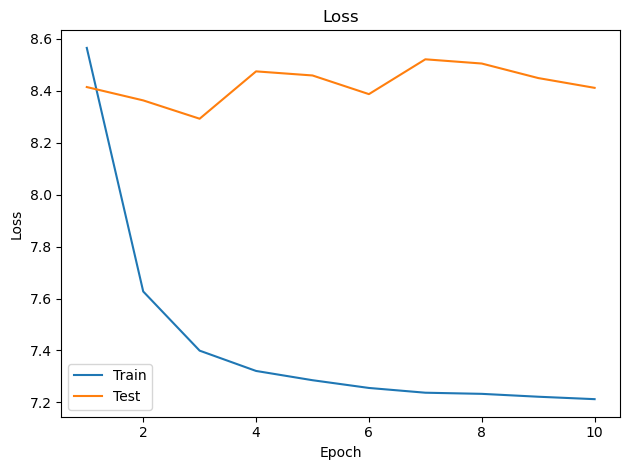

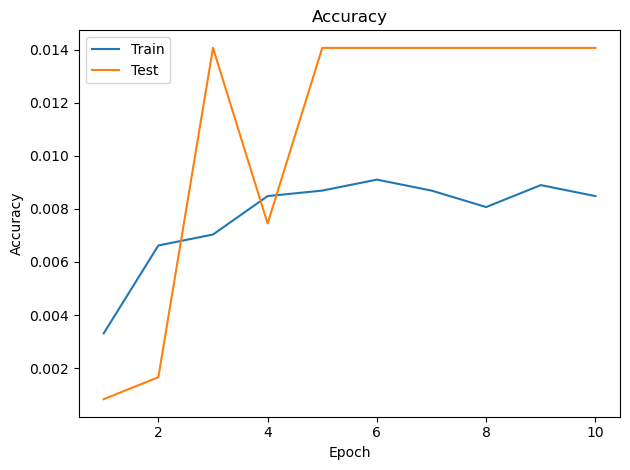

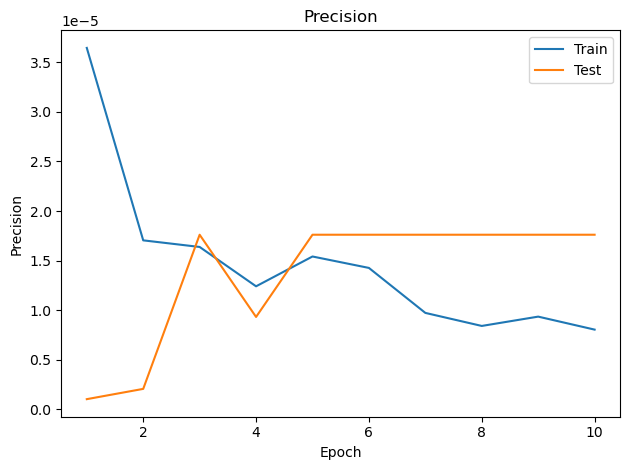

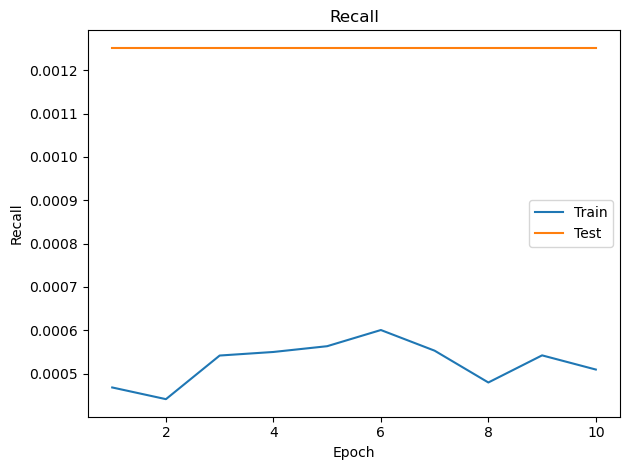

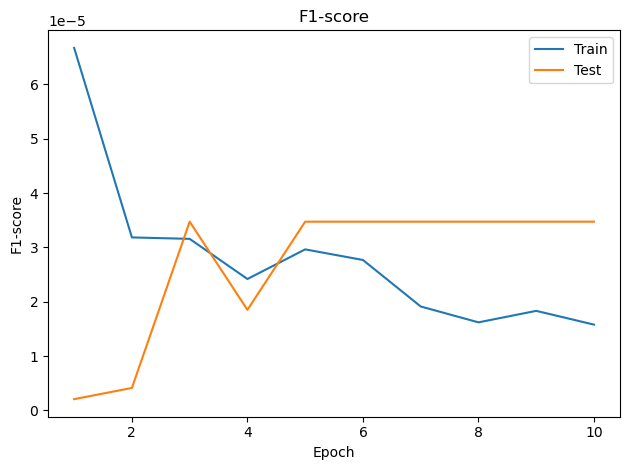

In [13]:
hist = train(model, train_loader, test_loader, epochs=10, lr=1e-3)
def plot_metric(train_key, test_key, title):
    xs = range(1, len(hist[train_key])+1)
    plt.figure()
    plt.plot(xs, hist[train_key], label="Train")
    plt.plot(xs, hist[test_key],  label="Test")
    plt.xlabel("Epoch")
    plt.ylabel(title)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_metric("train_loss", "test_loss", "Loss")
plot_metric("train_acc",  "test_acc",  "Accuracy")
plot_metric("train_prec", "test_prec", "Precision")
plot_metric("train_rec",  "test_rec",  "Recall")
plot_metric("train_f1",   "test_f1",   "F1‑score")